In [1]:
import pandas as pd
import io
import re
import csv
import json
import numpy as np
from numpy import savetxt, loadtxt, asarray
from tqdm import tqdm
import math
import ast
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import seaborn as sns
import keras
from keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from keras import Sequential, Model
from random import randrange
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from keras.utils.vis_utils import plot_model
import time
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


from plot_figures import save_model

pbar = ProgressBar()
tqdm.pandas()

Using TensorFlow backend.


In [2]:


max_blocks = 37 #(36 + 1 FC layer at the end)
#max_blocks = 36

nb_param =7
#nb_param =13
nb_hw_param = 12
#nb_param =12

inversed = True
only_inversed = False

if inversed and not only_inversed:
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/with_inversed_hw"
elif only_inversed:
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/only_inversed_hw"
else : 
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/no_inversed_hw"

BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100

DATASET_SIZE = 168308
train_size = int(0.90 * DATASET_SIZE) #135 805
test_size = int(0.10 * DATASET_SIZE) # 15 089

nb_training_batches = train_size //BATCH_SIZE +1
nb_test_batches = test_size //BATCH_SIZE +1

In [3]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))

# Load Proccessed Neural Networks (without HyperParameters)

In [4]:

#%pycache
path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_val_3.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_train_3.csv'

#path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/val_13.csv'
#path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/train_13.csv'


path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/val7_from1600.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/train7_from1600.csv'



#



# Power < 200

In [5]:
%pycache
path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/lower_power/parsed_nondups_val_lower_power.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/lower_power/parsed_nondups_train_lower_power.csv'

path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/lower_power/val_low_power.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/lower_power/train_low_power.csv'

UsageError: Line magic function `%pycache` not found.


In [6]:
#%pycache
tin= time.clock()

    
val = pd.read_csv(path_processed_val_nn,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train_nn,converters={'NN_dataframe': from_np_array})

tfin= time.clock()
print(f'Total time : {(tfin-tin)/60} min')

Total time : 1.5255195666666665 min


# Complete to zeros (max shape)

In [7]:
def get_shape(arr):
    return arr.shape[0]

def add_zero_blocks(arr):
    zero_blocks = np.zeros((max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val["nb_blocks"] = val["NN_dataframe"].apply(lambda x : get_shape(x))
train["nb_blocks"] = train["NN_dataframe"].apply(lambda x : get_shape(x))


val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))



# Get y_train, y_val


In [8]:
# To retrieve y_train / y_test

train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)

In [9]:
train_hw.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,G,C,B,J,name,bw_power,core_power,total_power
0,118.0,2.0,256.0,179968.0,2048.0,3.636011e+06,18770712.0,19987780.0,0.000533,0.0,79.951120,21.330414,101.281534
1,87.0,2.0,512.0,99968.0,2048.0,2.325259e+06,14362735.0,21849702.0,0.000570,0.0,87.398808,22.816285,110.215093
2,124.0,2.0,512.0,99968.0,3072.0,2.533459e+06,12739050.0,21849702.0,0.000543,0.0,87.398808,21.716202,109.115010
3,80.0,2.0,1024.0,99968.0,1024.0,2.327509e+06,12155422.0,21849702.0,0.000684,0.0,87.398808,27.343500,114.742308
4,86.0,2.0,512.0,60000.0,1536.0,1.728057e+06,16407889.0,28402776.0,0.000604,0.0,113.611104,24.174307,137.785411


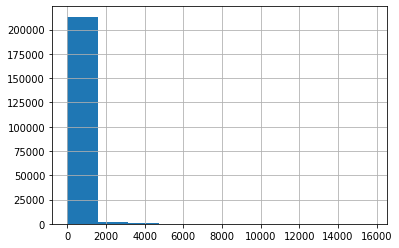

In [10]:
train_hw["total_power"].hist()

In [11]:
len(train_hw["total_power"].unique())

198167

--------
# HW PARAM ALONE

In [12]:
X_train_hw_param  = train_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_train_hw_param['tot_mac'] = X_train_hw_param['mac_num']*X_train_hw_param['mac_array_num']

X_val_hw_param  = val_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_val_hw_param['tot_mac'] = X_val_hw_param['mac_num']*X_val_hw_param['mac_array_num']

X_train_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac
0,118.0,2.0,256.0,179968.0,2048.0,236.0
1,87.0,2.0,512.0,99968.0,2048.0,174.0
2,124.0,2.0,512.0,99968.0,3072.0,248.0
3,80.0,2.0,1024.0,99968.0,1024.0,160.0
4,86.0,2.0,512.0,60000.0,1536.0,172.0


# Shapes of the blocks

In [13]:
X_train_shape = np.array(train["nb_blocks"])
X_val_shape = np.array(val["nb_blocks"])

#X_val_shape

# Inv

In [14]:
def inv(x):
    return 1/(1+x)


if inversed : 
#nb_hw_param = 6
    nb_hw_param = 12
    X_train_hw_param['1/mac_num'] = X_train_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/mac_array_num'] = X_train_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/data_bits'] = X_train_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/sram_size'] = X_train_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/max_filter_size'] = X_train_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/tot_mac'] = X_train_hw_param['tot_mac'].progress_apply(lambda x : inv(x))


    X_val_hw_param['1/mac_num'] = X_val_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/mac_array_num'] = X_val_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/data_bits'] = X_val_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/sram_size'] = X_val_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/max_filter_size'] = X_val_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/tot_mac'] = X_val_hw_param['tot_mac'].progress_apply(lambda x : inv(x))

if only_inversed : 
    nb_hw_param = 6
    inv = ['1/mac_num','1/mac_array_num','1/data_bits','1/sram_size','1/max_filter_size','1/tot_mac']
    X_train_hw_param =X_train_hw_param.loc[:, inv]
    X_val_hw_param =X_val_hw_param.loc[:, inv]


100%|██████████| 24274/24274 [00:00<00:00, 490454.82it/s]


In [15]:
X_val_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac,1/mac_num,1/mac_array_num,1/data_bits,1/sram_size,1/max_filter_size,1/tot_mac
0,37.0,2.0,128.0,199936.0,4098.0,74.0,0.026316,0.333333,0.007752,0.000005,0.000244,0.013333
1,91.0,2.0,256.0,119936.0,2048.0,182.0,0.010870,0.333333,0.003891,0.000008,0.000488,0.005464
2,74.0,2.0,256.0,139904.0,1024.0,148.0,0.013333,0.333333,0.003891,0.000007,0.000976,0.006711
3,70.0,2.0,512.0,80000.0,512.0,140.0,0.014085,0.333333,0.001949,0.000012,0.001949,0.007092
4,103.0,2.0,256.0,199936.0,4098.0,206.0,0.009615,0.333333,0.003891,0.000005,0.000244,0.004831


## HW Normalize

In [16]:
# normalize

#%pycache
# Process
scaler = preprocessing.StandardScaler().fit(X_train_hw_param)
X_train_hw_param_norm= scaler.transform(X_train_hw_param)
X_val_hw_param_norm = scaler.transform(X_val_hw_param )


In [17]:
pd.DataFrame(X_train_hw_param_norm).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.855641,-0.489793,-0.647015,0.529144,0.332994,-0.239695,-0.662872,0.706748,0.103602,-0.981619,-0.778893,-0.505309
1,0.300127,-0.489793,-0.258452,-0.373136,0.332994,-0.306012,-0.581406,0.706748,-0.569281,-0.066708,-0.778893,-0.411430
2,0.963160,-0.489793,-0.258452,-0.373136,1.196488,-0.226860,-0.673972,0.706748,-0.569281,-0.066708,-1.029986,-0.518079
3,0.174689,-0.489793,0.518673,-0.373136,-0.530500,-0.320987,-0.554381,0.706748,-0.906707,-0.066708,-0.026105,-0.380224
4,0.282208,-0.489793,-0.258452,-0.823915,-0.098753,-0.308151,-0.577812,0.706748,-0.569281,1.304303,-0.527882,-0.407281


In [18]:
pd.DataFrame(X_train_hw_param).head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac,1/mac_num,1/mac_array_num,1/data_bits,1/sram_size,1/max_filter_size,1/tot_mac
0,118.0,2.0,256.0,179968.0,2048.0,236.0,0.008403,0.333333,0.003891,0.000006,0.000488,0.004219
1,87.0,2.0,512.0,99968.0,2048.0,174.0,0.011364,0.333333,0.001949,0.000010,0.000488,0.005714
2,124.0,2.0,512.0,99968.0,3072.0,248.0,0.008000,0.333333,0.001949,0.000010,0.000325,0.004016
3,80.0,2.0,1024.0,99968.0,1024.0,160.0,0.012346,0.333333,0.000976,0.000010,0.000976,0.006211
4,86.0,2.0,512.0,60000.0,1536.0,172.0,0.011494,0.333333,0.001949,0.000017,0.000651,0.005780


## Datasets for HW param

In [19]:
%pycache
X_hw_norm = np.concatenate((X_train_hw_param_norm, X_val_hw_param_norm))
X_hw = np.concatenate((X_train_hw_param, X_val_hw_param))
y = np.concatenate((y_train, y_val))

# Mix train/test
#NORMED
dataset_hw_norm = tf.data.Dataset.from_tensor_slices((X_hw_norm, y))
dataset_hw_norm= dataset_hw_norm.shuffle(SHUFFLE_BUFFER_SIZE)
#UNORMED
dataset_hw = tf.data.Dataset.from_tensor_slices((X_hw, y))
#small_dataset_hw = dataset_hw.filter(lambda x, label: label<100)
dataset_hw= dataset_hw.shuffle(SHUFFLE_BUFFER_SIZE)

# Split them
#NORMED
train_dataset_hw_norm =  dataset_hw_norm.take(train_size).batch(BATCH_SIZE)
test_dataset_hw_norm = dataset_hw_norm.skip(train_size).batch(BATCH_SIZE)

#UNORMODED
train_dataset_hw =  dataset_hw.take(train_size).batch(BATCH_SIZE)
test_dataset_hw = dataset_hw.skip(train_size).batch(BATCH_SIZE)


UsageError: Line magic function `%pycache` not found.


------------

# NN TREATEMENT ALONE

In [20]:


X_train_nn =np.array(train['NN_dataframe'].tolist())
X_val_nn = np.array(val['NN_dataframe'].tolist())

## NN Normalize

### Divde columns by standard deviation

In [21]:


means = []
std = []
X_train_nn_norm=X_train_nn.copy()
X_val_nn_norm = X_val_nn.copy()
for i in range(nb_param):
    #means.append(np.mean(X_train_nn[:,:,i]))
    #X_train_nn[:,:,i]=-means[i]
    std.append(np.std(X_train_nn[:,:,i]))
    if std[i]!=0:
        X_train_nn_norm[:,:,i]/= std[i]
        X_val_nn_norm[:,:,i]/= std[i]  

#savetxt('std.csv', std, delimiter=',')
#data = loadtxt('std.csv', delimiter=',')

In [22]:
std

[277884802.5673081,
 461103.7972515926,
 136894.47844820443,
 138975.80512235846,
 311.8400298266541,
 12.189058828019654,
 0.394164309098097]

In [23]:
pd.DataFrame(X_train_nn_norm[0]).head()

,0,1,2,3,4,5,6
0,0.021939,0.000547,1.099591,0.812343,0.009620,0.738367,0.0
1,0.007313,0.000195,0.824694,0.812343,0.028861,0.738367,0.0
2,0.006500,0.000173,0.824694,0.722083,0.028861,0.082041,0.0
3,0.201509,0.004908,0.733061,2.798070,0.025654,0.738367,0.0
4,0.906793,0.022409,2.840611,3.700673,0.397640,0.738367,0.0


## Datasets for NN

In [24]:
%pycache
X_nn_norm = np.concatenate((X_train_nn_norm, X_val_nn_norm))
X_nn = np.concatenate((X_train_nn, X_val_nn))
y = np.concatenate((y_train, y_val))

# Mix test/train 
#NORMED
dataset_nn_norm = tf.data.Dataset.from_tensor_slices((X_nn_norm, y))
dataset_nn_norm= dataset_nn_norm.shuffle(SHUFFLE_BUFFER_SIZE)

#UNNORMED
dataset_nn = tf.data.Dataset.from_tensor_slices((X_nn, y))
dataset_nn.shuffle(SHUFFLE_BUFFER_SIZE)


# Split them
#NORMED
test_dataset_nn_norm = dataset_nn_norm.take(test_size).batch(BATCH_SIZE)
train_dataset_nn_norm = dataset_nn_norm.skip(test_size).batch(BATCH_SIZE)

#UNORMED
test_dataset_nn= dataset_nn.take(test_size).batch(BATCH_SIZE)
train_dataset_nn = dataset_nn.skip(test_size).batch(BATCH_SIZE)

UsageError: Line magic function `%pycache` not found.


In [25]:
#a=np.array(list(zip(X_train_nn_norm, X_train_shape)))
X_train_nn_norm_zip =  np.array( [(one,two) for one, two in zip(X_train_nn_norm, X_train_shape)]   )
X_val_nn_norm_zip =  np.array( [(one,two) for one, two in zip(X_val_nn_norm, X_val_shape)]   )

In [26]:
type(X_train_hw_param_norm)

numpy.ndarray

In [27]:
type(X_train_nn_norm_zip)

numpy.ndarray

# Full Dataset (HW_params + NN arrays)

In [164]:
train_blocks = []
for sha in X_train_shape:
    ones = np.ones((sha, 32))
    zeros = np.zeros((37-sha,32))
    train_blocks.append(np.concatenate((ones,zeros)))
train_blocks = np.array(train_blocks)


val_blocks = []
for sha in X_val_shape:
    ones = np.ones((sha, 32))
    zeros = np.zeros((37-sha,32))
    val_blocks.append(np.concatenate((ones,zeros)))
val_blocks = np.array(val_blocks)

In [209]:
#NORMED
#train_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_train_nn_norm, X_train_hw_param_norm), y_train))
#test_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_val_nn_norm, X_val_hw_param_norm), y_val))

train_dataset_norm = tf.data.Dataset.from_tensor_slices(( (train_blocks,X_train_nn_norm, X_train_hw_param_norm), y_train) )
test_dataset_norm = tf.data.Dataset.from_tensor_slices(( (val_blocks,X_val_nn_norm, X_val_hw_param_norm), y_val) )

train_dataset_norm = train_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE)
test_dataset_norm = test_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE)

train_dataset_norm = train_dataset_norm.batch(BATCH_SIZE)
test_dataset_norm = test_dataset_norm.batch(BATCH_SIZE)


# Get loss/model

## Models

In [210]:
name_test = 'model_1_plus'
from tensorflow.keras import Input

sha = X_train_shape[0]

In [211]:
train_blocks.shape

(215445, 37, 32)

In [212]:
ones = tf.Variable(np.ones((37,last_layer)),shape=(37,last_layer),name="a")
last_layer=32
shape =tf.convert_to_tensor(np.array(X_val_shape))[10000]
ind =[[i] for i in range(shape)]
ones_blocks = tf.gather_nd(zeros,ind)

In [213]:
%pycache
keras_input = tf.keras.layers.Input([1],dtype='int64')
keras_input

#shape =tf.convert_to_tensor(np.array(X_val_shape))[10000]
zeros= tf.Variable(np.zeros((37-(keras_input), last_layer), dtype=np.float32), name='vector_zeros')
#ones =tf.Variable(np.ones((shape, last_layer), dtype=np.float32), name='vector_ones')
block = tf.concat([ones,zeros],0)

UsageError: Line magic function `%pycache` not found.


In [214]:
tf.keras.layers.multiply([output_nn, input_blocks])

<tf.Tensor 'multiply_22/Identity:0' shape=(None, 37, 32) dtype=float32>

In [215]:
last_layer = 32
input_blocks = Input(shape=(max_blocks, last_layer),dtype='float32', name='blocks')
input_nn = Input(shape=(max_blocks, nb_param), dtype='float32', name='input_nn')


output_nn = layers.Conv1D(128, (2), activation='relu', padding="same")(input_nn)
output_nn = layers.Conv1D(last_layer , (2), activation='relu', padding="same")(output_nn)
output_nn = tf.keras.layers.multiply([output_nn, input_blocks])
#output_nn =layers.Lambda(lambda x: x * input_blocks)(output_nn)
output_nn =tf.keras.layers.Lambda( lambda x: K.sum(x, axis=1))(output_nn)


model_hw = tf.keras.Sequential([
     layers.Dense(32, activation='relu', input_shape=(nb_hw_param,)),
     layers.Dense(last_layer , activation='linear')
 ])

#concat = tf.keras.layers.Concatenate()([model_nn.output, model_hw.output])
#concat = tf.keras.layers.multiply([model_nn.output, model_hw.output])
concat = tf.keras.layers.multiply([output_nn, model_hw.output])
concat = tf.keras.layers.Concatenate()([concat,output_nn, model_hw.output])

output = tf.keras.layers.Dense(units=32, activation='relu')(concat)
output = tf.keras.layers.Dense(units=32, activation='relu')(output)
output = tf.keras.layers.Dense(units=1, activation='relu')(output)
#full_model = tf.keras.Model(inputs=[input_nn, model_hw.input], outputs=[output])
full_model = tf.keras.Model(inputs=[input_blocks, input_nn, model_hw.input], outputs=[output])
Wsave =full_model.get_weights()

print(f'PARAMS : {full_model.count_params()}')

PARAMS : 15809


In [216]:
def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Test entire model

In [218]:
#%pycache

full_epochs = 20

print(f'PARAMS : {full_model.count_params()}')
t4= time.clock()
full_model.compile(optimizer=optimizer, loss=loss)

history = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=full_epochs,
         verbose=1,
 )

t5= time.clock()


print(f'Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')

PARAMS : 15809
Epoch 1/20
106/106 [==============================] - 28s 264ms/step - loss: 0.2973 - val_loss: 0.2649
Epoch 2/20
106/106 [==============================] - 32s 306ms/step - loss: 0.2640 - val_loss: 0.2416
Epoch 3/20
106/106 [==============================] - 27s 250ms/step - loss: 0.2647 - val_loss: 0.2551
Epoch 4/20
106/106 [==============================] - 32s 299ms/step - loss: 0.2478 - val_loss: 0.2359
Epoch 5/20
106/106 [==============================] - 23s 217ms/step - loss: 0.2243 - val_loss: 0.2289
Epoch 6/20
106/106 [==============================] - 27s 257ms/step - loss: 0.2104 - val_loss: 0.2133
Epoch 7/20
106/106 [==============================] - 24s 223ms/step - loss: 0.1989 - val_loss: 0.2072
Epoch 8/20
106/106 [==============================] - 23s 214ms/step - loss: 0.1892 - val_loss: 0.2011
Epoch 9/20
106/106 [==============================] - 23s 216ms/step - loss: 0.1853 - val_loss: 0.2044
Epoch 10/20
106/106 [==============================] - 23s

In [99]:
%pycache
model_path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/model_1_12161_param_0.131_error/model_1_plus_12161_param"
full_model.load_weights(model_path)



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x1a7a1b6780> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1a7a1bb668>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x1a7a1b8400> and <tensorflow.python.keras.layers.core.Lambda object at 0x1a7a1b8390>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x1a7a1bec50> and <tensorflow.python.keras.layers.core.Lambda object at 0x1a7a1b83c8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x1a7a1bbf98> and <tensorflow.python.keras.layers.merge.Multiply object at 0x1a7a1bb828>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x1a7a1e18d0> and <tensorflow.python.keras.layers.core.Dense object a

In [119]:
X_list = [X_val_nn_norm, X_val_hw_param_norm]
inputs2=[]
for x in range(len (X_list)):    
    input_x=np.array(X_list[x])[0]
    input_x=input_x.reshape((1,*input_x.shape))
    inputs2.append(tf.convert_to_tensor(input_x))
full_model(inputs2)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.6779374]], dtype=float32)>

In [111]:
  # hw_array = np.array([ 0.8552576 , -0.47734305, -0.62680401,  0.57911723,  0.37841259,
  #    -0.23434365, -0.64634273,  0.68297377,  0.06787059, -1.01696994,
  #    -0.81343443, -0.49667088])
  hw_array = np.array([ 10,100000,100000,10000,0,0,0,0,0,0,0,0])
  hw_array = hw_array.reshape((1, *hw_array.shape))
  hw_array = tf.convert_to_tensor(hw_array, dtype=np.float32)

full_model([nn_array_2, hw_array])


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.6779374]], dtype=float32)>

In [ ]:
# 20,000 param
## 25 epochs :  41 min

# 12 000 param
## 25 epochs: 30 min

## 10,785 params:
### 25 epochs : 56 min
### 15 epochs : 34 min
</br>

## 31 000
### **20 epochs : 25 min**
 </br>

## 57,009 params
### 20 epochs : 101 min 
</br>

##62,465 pames
### 30 epochs : 78 min
 </br>

## 143,345 params
### 20 epochs : 276 min 
</br>



In [129]:
#%pycache

t5= time.clock()
nb_final_epochs_for_mean = 5
print(f'PARAMS : {full_model.count_params()}')
name = f'{name_test}_{full_model.count_params()}_param'
save = True

nb_predictions = 1
max_val_loss=0.7



model = full_model
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]
history = history

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path_entire_model, model= model, history=history, X_list=X_val_list, y=y_val, std=std, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)

#savetxt(f'{path_entire_model}/{name}/std.csv', std, delimiter=',')


t6= time.clock()


PARAMS : 4897


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [83]:
#%pycache
print(f'Total time : {(t6-t5)/60} min')

Total time : 0.11341751666667127 min


In [40]:
#%pycache
checkpoint_path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/with_inversed_hw/model_1_plus_12161_param_0.131_error/model_1_plus_12161_param"


full_model.load_weights(checkpoint_path)
#results = full_model.evaluate(test_dataset_norm)

# Test size dataset - More data?

In [41]:

#%pycache
path_test_dataset = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/size_dataset/test_size_dataset_4"

print(f'PARAMS : {full_model.count_params()}')
nb_final_epochs_for_mean = 5
save = True
nb_predictions = 100
max_val_loss=50
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]


full_epochs = 25
test_performances = {}
#percents = [0.97]
percents = [0.25, 0.50, 0.75, 0.85, 0.90, 1]
mini_batches_list = l = [int(x * nb_training_batches) for x in percents]

for i, mini_batches in enumerate(mini_batches_list):
    print()
    full_model.set_weights(Wsave)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_dataset_percent_norm =train_dataset_norm.take(mini_batches)
    t4= time.clock()
    full_model.compile(optimizer=optimizer, loss=loss)
    
    history = full_model.fit(train_dataset_percent_norm,
            validation_data=(test_dataset_norm),
            epochs=full_epochs,
            verbose=1,
    )

    t5= time.clock()
    print(f'Mini_batch percent: {percents[i]} Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')
    name = f'percent_{percents[i]}'
    test_performances[percents[i]] =  np.mean((history.history["val_loss"][-nb_final_epochs_for_mean:]))

    save_model(path=path_test_dataset, model= full_model, history=history, X_list=X_val_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)



PARAMS : 12161


NameError: name 'X_val_nn_norm' is not defined

In [42]:
test_performances_save = {0.25: 0.2629273136456808,
 0.5: 0.23724876874023018,
 0.75: 0.21560097336769105,
 0.85: 0.19926969276534187,
 0.87: 0.18293529417779708,
 0.9: 0.17390226572752,
 0.95: 0.1793243298927943,
 0.97: 0.18094,
 1: 0.1743503441413244}

In [44]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_input (InputLayer)       [(None, 37, 7)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 37, 128)      1920        conv1d_input[0][0]               
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 12)]         0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 37, 32)       8224        conv1d[0][0]                     
______________________________________________________________________________________________

In [45]:

plt.figure()
lists = sorted(test_performances.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)

plt.title('Influence size train dataset')
plt.ylabel('Mean error on last epochs')
plt.xlabel('Percent train dataset')
plt.legend(['test'], loc='upper left')

NameError: name 'test_performances' is not defined

In [45]:
%pycache
high_powers= [128,256,512,1024]
low_power = [16,32,64]
depths = [1,2,3,4,5,6]
begining 

def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

for ind,power in enumerate(powers):
    for depth in depths[:len(depths)-ind]:
        model_nn = tf.keras.Sequential()
        model_nn.add(layers.Conv1D(power, (3), activation='relu', padding="same",input_shape=(max_blocks, nb_param)))
        for i in range(depth):
            model_nn.add(layers.Conv1D(power, (3), activation='relu', padding="same"))
        model_nn.add(layers.Lambda( lambda x: K.sum(x, axis=1)))
        
        model_hw = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(nb_hw_param,)),
        layers.Dense(power, activation='linear')
        ])

        concat = tf.keras.layers.multiply([model_nn.output, model_hw.output])
        output = tf.keras.layers.Dense(units=16, activation='relu')(concat)
        output = tf.keras.layers.Dense(units=1, activation='relu')(output)
        full_model = tf.keras.Model(inputs=[model_nn.input, model_hw.input], outputs=[output])
       
        # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        # initial_learning_rate=1e-2,
        # decay_steps=nb_training_batches,
        # decay_rate=0.95)
        # optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        # full_epochs = 1

        # print(f'PARAMS : {full_model.count_params()}')
        # t4= time.clock()
        # full_model.compile(optimizer=optimizer, loss=loss)
        # history = full_model.fit(train_dataset_norm,
        #         validation_data=(test_dataset_norm),
        #         epochs=full_epochs,
        #         verbose=1, )
        # t5= time.clock()
        # print(f'Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')
        # t5= time.clock()
        # nb_final_epochs_for_mean = 5
        # print(f'PARAMS : {full_model.count_params()}')
        name = f'power_{power}_depth_{depth}_{full_model.count_params()}_param'
        print(nb_repeat)
        #print(depth)
        print()
        # save = True

        # nb_predictions = 100
        # max_val_loss=0.7

        # model = full_model
        # X_val_list = [X_val_nn_norm, X_val_hw_param_norm]

        # save_model(path=path_entire_model, model= model, history=history, X_list=X_val_list, y=y_val, std=std, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)




UsageError: Line magic function `%pycache` not found.
